## Library Import

In [1]:
# Importing necessary library
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from matplotlib import rcParams
from matplotlib.ticker import LinearLocator
import pywt
import pandas as pd
import os
import time
from scipy import signal
from stingray import lightcurve
import sys
from stingray import Bispectrum
import warnings
import csv
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
c:\Users\fulky\anaconda3\envs\skripsi\lib\site-packages\stingray\utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## General Function

In [2]:
# file that will be skipped because of information loss
zeros_test = ['co2a0000368_91.csv', 'co2c0000341_26.csv']
zeros_train = ['co2a0000368_0.csv', 'co2a0000368_1.csv', 'co2a0000368_2.csv', 'co2a0000368_3.csv', 'co2a0000368_4.csv', 'co2a0000368_5.csv', 'co2c0000341_27.csv']

# Define sampling frequency
fs = 256
t = np.arange(0, 1, 1/fs)

def get_dummy(directory, lag):
    for foldername in os.listdir(directory):
        folder = os.path.join(directory, foldername)
        if os.path.isdir(folder):
            # des_dir = os.path.join(directory.replace('CSV', 'FEATURE')+"_" + str(lag),foldername).lower()
            files = os.listdir(folder)
            for filename in files:
                rel_path = os.path.join(directory, foldername, filename)
                if 'metadata' in filename.lower():
                    continue
                trial_number = filename.split('.')[0].split('_')[1]
                df_data, channel_name = get_csv_EEG(rel_path)
                RWB = []
                return df_data[channel_name[2]]
                # pd.DataFrame(RWB.T).to_csv(des_path, index=False)
                
def get_csv_EEG(filename):
    # Load data from CSV
    data = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=range(3,259))
    channel_name = np.loadtxt(filename, delimiter=",", skiprows=1, usecols=1, dtype='str', encoding='utf-8')
    
    df_data = pd.DataFrame(data.T, columns=channel_name)

    df_data = df_data.drop(columns=['X', 'Y', 'nd'])

    return df_data, df_data.columns

## RWB Visualization

In [5]:

def calcCumulantOrde3(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contour plots
    # plt.contour(bs.freq, bs.freq, bs.bispec_mag)
    # plt.xlabel('f1')
    # plt.ylabel('f2')
    # plt.show()

    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))

    # # Make data.
    # X, Y = np.meshgrid(bs.freq, bs.freq)

    # # Plot the surface.
    # surf = ax.plot_surface(X, Y, bs.cum3, cmap=cm.coolwarm,
    #                     linewidth=0, antialiased=True)

    # # Customize the z axis.
    # # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # # A StrMethodFormatter is used automatically
    # ax.zaxis.set_major_formatter('{x:.02f}')

    # # Add a color bar which maps values to colors.
    # fig.colorbar(surf, shrink=0.5, aspect=5)

    # plt.show()
    # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(bs.freq, bs.freq)
    # ax.plot_surface(X, Y, bs.cum3)
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    return bs

def calcWaveletDec(bs):
    # Select wavelet and decomposition level
    wavelet = 'db4'
    level = 5

    # Deecompose signal
    coeffs = pywt.wavedec2(bs.cum3, wavelet, level=level)
    # Plot the bispectrum using mesh plots
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    # ax.plot_surface(X, Y, coeffs[0])
    # ax.set_xlabel('f1')
    # ax.set_ylabel('f2')
    # ax.set_zlabel('Bispectrum')
    # plt.show()

    x, y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))
    z = coeffs[0]
    z = z[:-1, :-1]
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()
    
    plt.subplot()
    
    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')
    
    plt.title('Approximation')
    
    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    
    plt.colorbar()
    plt.show()

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 5))

    # # Make data.
    X, Y = np.meshgrid(np.arange(len(coeffs[0])), np.arange(len(coeffs[0][0])))

    # Plot the surface.
    surf = ax.plot_surface(X, Y, coeffs[0], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(min(coeffs[0].all()), max(coeffs[0].all()))
    ax.zaxis.set_major_locator(LinearLocator(5))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.75, aspect=20)
    # Visualize
    plt.show()
    
    cA5 = coeffs[0][np.triu(np.ones_like(coeffs[0], dtype=bool))]
    cD5 = np.ravel([coeffs[1][0], coeffs[1][1], coeffs[1][2]])
    cD4 = np.ravel([coeffs[2][0], coeffs[2][1], coeffs[2][2]])
    cD3 = np.ravel([coeffs[3][0], coeffs[3][1], coeffs[3][2]])
    cD2 = np.ravel([coeffs[4][0], coeffs[4][1], coeffs[4][2]])
    cD1 = np.ravel([coeffs[5][0], coeffs[5][1], coeffs[5][2]])
    
    coeff = [cA5,cD5,cD4,cD3,cD2,cD1]
    
    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD5)), cD5, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 5')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD4)), cD4, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 4')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD3)), cD3, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 3')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD2)), cD2, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 2')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(np.arange(len(cD1)), cD1, color = 'k', linewidth=1)
    plt.title(f'Detail - Level 1')
    plt.show()


    return coeffs


def calcRelativeEnergy(coeffs, df_data):
    # Calculate relative wavelet energy
    energies = []
    for c in coeffs:
        energies.append(np.sum(np.square(c)))

    decomp = ['A5', 'D1', 'D2', 'D3', 'D4', 'D5']

    energies[1:6] = energies[-1:-6:-1]

    total_energy = np.sum(energies)
    relative_energies = [(e / total_energy) * 100 for e in energies]

    # print(relative_energies)

    # plt.plot(decomp, energies)
    # plt.xlabel('Dimension Number')
    # plt.ylabel('Wavelet Bispectrum Energy')
    # plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(decomp, relative_energies, color = 'k', linewidth=1)
    plt.xlabel('Dimension Number')
    plt.ylabel('Relative Wavelet Bispectrum Energy')
    plt.show()

    return energies, relative_energies

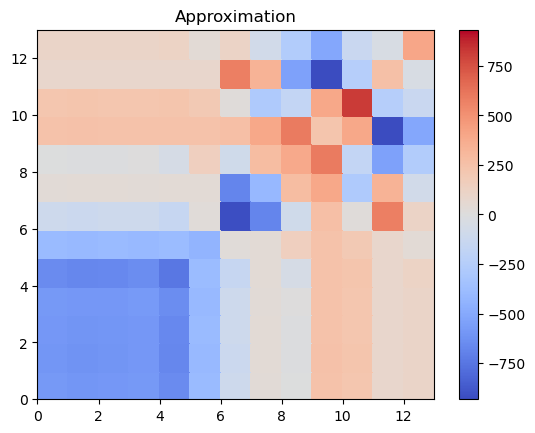

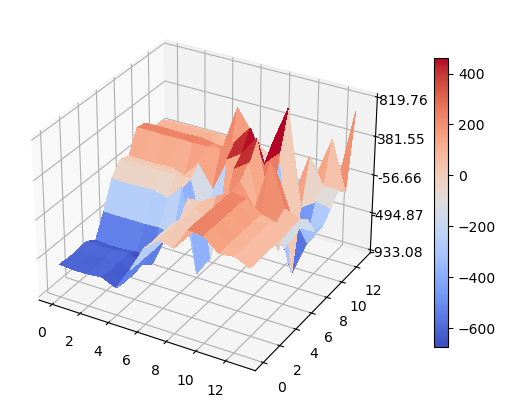

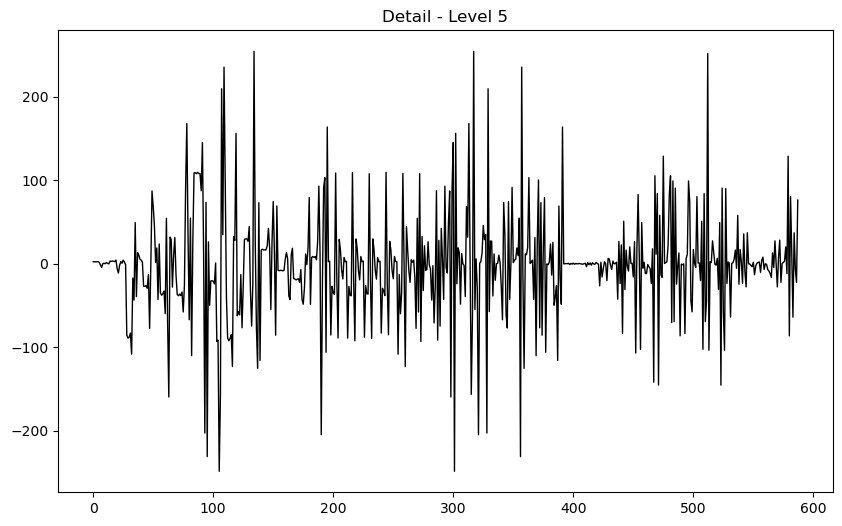

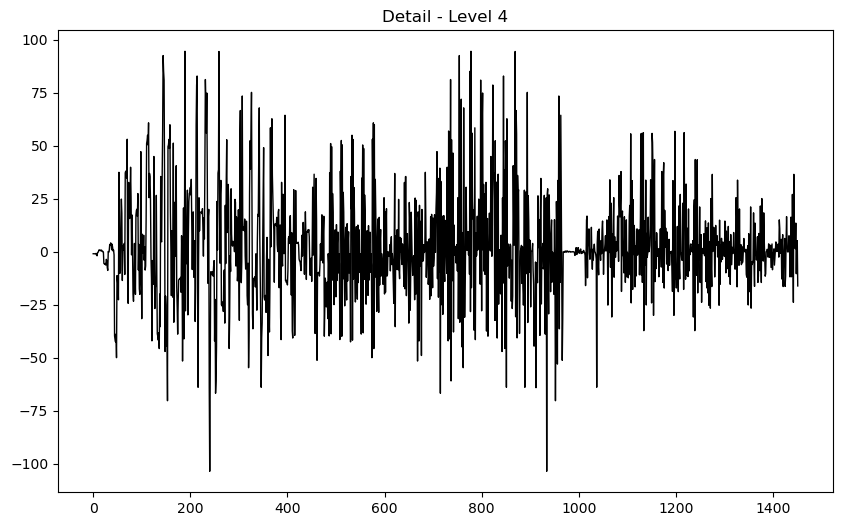

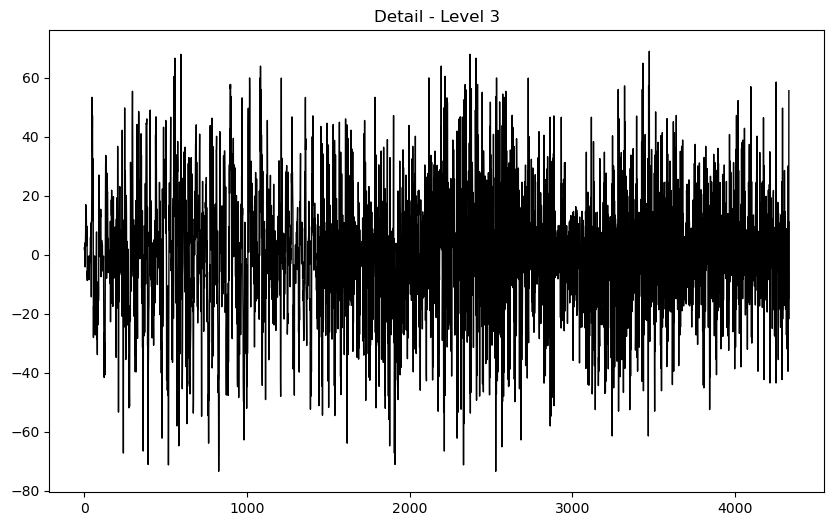

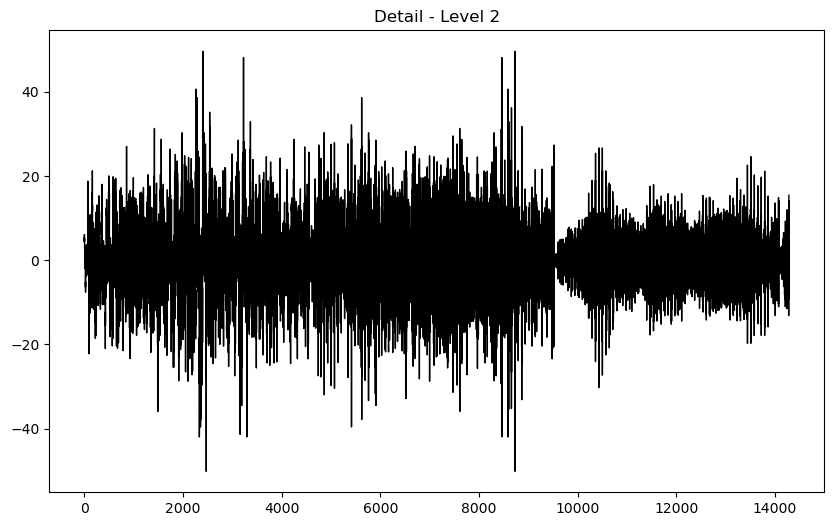

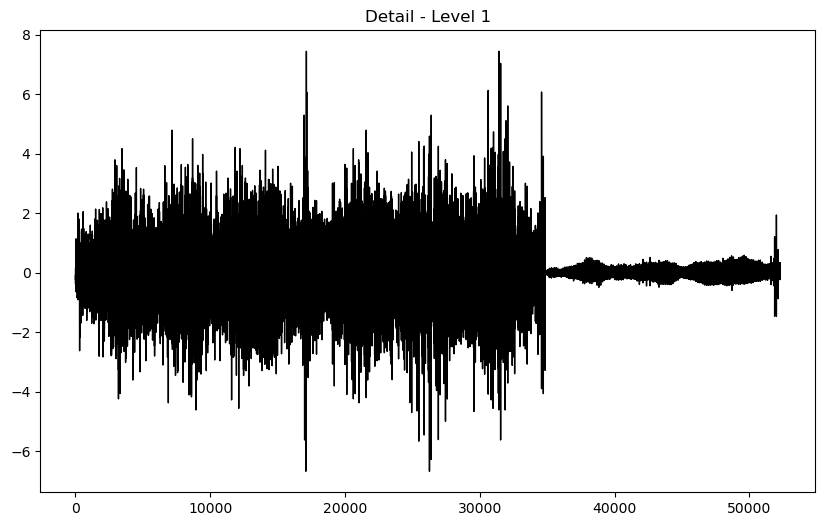

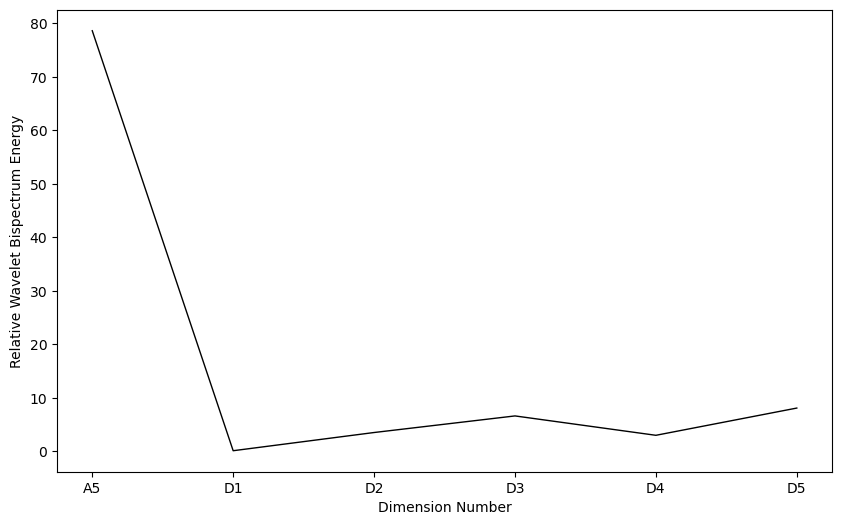

In [9]:
lag = 128
dummy = get_dummy('../SMNI_CMI_TEST_CSV', lag)
relative_energies = calcRelativeEnergy(calcWaveletDec(calcCumulantOrde3(dummy, t, lag)), dummy)


## Bispectrum Visualization

In [17]:
def calcBispec(df_data, t, lag):
    # Compute the bispectrum of the signal
    lc = lightcurve.Lightcurve(t,df_data.T)
    bs = Bispectrum(lc, maxlag=lag)

    # Plot the bispectrum using contourf plots
    plt.contourf(bs.freq, bs.freq, bs.bispec_mag, cmap =cm.coolwarm)
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # plt.subplots_adjust(right=2)
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(bs.freq, bs.freq)
    ax.plot_surface(X, Y, bs.bispec_mag, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    temp = bs.bispec_mag[:lag, :lag]
    freq_temp = bs.freq[:lag]

    # Plot the bispectrum using contourf plots
    plt.contourf(freq_temp, freq_temp, temp, cmap =cm.coolwarm)
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(freq_temp, freq_temp)
    ax.plot_surface(X, Y, temp, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    temp2 = temp[(lag//2)+30:, (lag//2)+30:]
    freq_temp2 = freq_temp[(lag//2)+30:]

    # Plot the bispectrum using contourf plots
    plt.contourf(freq_temp2, freq_temp2, temp2, cmap =cm.coolwarm)
    plt.xlabel('f1')
    plt.ylabel('f2')
    plt.colorbar()
    plt.show()

    # Plot the bispectrum using mesh plots
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(freq_temp2, freq_temp2)
    ax.plot_surface(X, Y, temp2, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    return bs.bispec_mag

def gkernel(k=2, l=1, sig=20):
    """
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    bx = np.linspace(-(k - 1) / 2., (k - 1) / 2., k)

    xx, yy = np.meshgrid(ax, bx)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.max(kernel)

def create_feature(bispectrum, pyramid, fil_size, bis_dim):
    fsize = len(fil_size)
    feature_matrix = np.zeros([fsize,fsize])
    filtered_array = np.zeros([bis_dim,bis_dim])
    xtrack = 0
    ytrack = 0
    for xdim in range(fsize):
        for ydim in range(fsize):
            x,y = fil_size[xdim], fil_size[ydim]
            filtered_array[xtrack:xtrack+x, ytrack:ytrack+y] = bispectrum[xtrack:xtrack+x, ytrack:ytrack+y] * pyramid[xtrack:xtrack+x, ytrack:ytrack+y]
            feature_matrix[xdim][ydim] = np.mean(filtered_array[xtrack:xtrack+x, ytrack:ytrack+y])
            ytrack = ytrack+y
        ytrack = 0
        xtrack = xtrack+x
    final_feature = feature_matrix[np.triu(np.ones_like(feature_matrix, dtype=bool))]
    final_feature = final_feature[~np.isnan(final_feature)]

    # FILTER
    x, y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    z = pyramid
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filter')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    ax.plot_surface(X, Y, pyramid, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FILTERED MATRIX
    x, y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    z = filtered_array
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filtered Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(bis_dim), np.arange(bis_dim))
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    ax.plot_surface(X, Y, filtered_array, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # ZOOMED RESULT

    temp = filtered_array[(lag//2)+30:, (lag//2)+30:]

    x, y = np.meshgrid(np.arange(len(temp)), np.arange(len(temp)))
    z = temp
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Filtered Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(len(temp)), np.arange(len(temp)))
    ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    ax.plot_surface(X, Y, temp, cmap =cm.coolwarm)
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FEATURE MATRIX
    x, y = np.meshgrid(np.arange(fsize), np.arange(fsize))
    z = feature_matrix
    z = z[:-1, :-1]
    z_min, z_max = 0, np.abs(z).max()
    print(z_max)
    plt.subplot()

    plt.pcolormesh(x, y, z, 
                cmap =cm.coolwarm, 
                vmin = z_min, 
                vmax = z_max,
                edgecolors = 'face',
                shading ='flat')

    plt.title('Feature Matrix')

    # set the limits of the plot
    # to the limits of the data
    plt.axis([x.min(), x.max(), y.min(), y.max()])

    plt.colorbar()
    plt.show()

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    # ax.zaxis.set_major_formatter(ticker.EngFormatter(unit=''))
    X, Y = np.meshgrid(np.arange(fsize), np.arange(fsize))
    print(X,Y)
    ax.plot_surface(X, Y, feature_matrix, cmap =cm.coolwarm)
    # ax.xaxis.set_major_locator(LinearLocator(5))
    # ax.yaxis.set_major_locator(LinearLocator(5))
    ax.set_xlabel('f1')
    ax.set_ylabel('f2')
    plt.show()

    # FINAL FEATURE
    t = range(len(final_feature))

    plt.figure(figsize=(10,6))
    plt.plot(t, final_feature, color = 'k', linewidth=1)
    plt.show()

    return final_feature


### Run Visualization

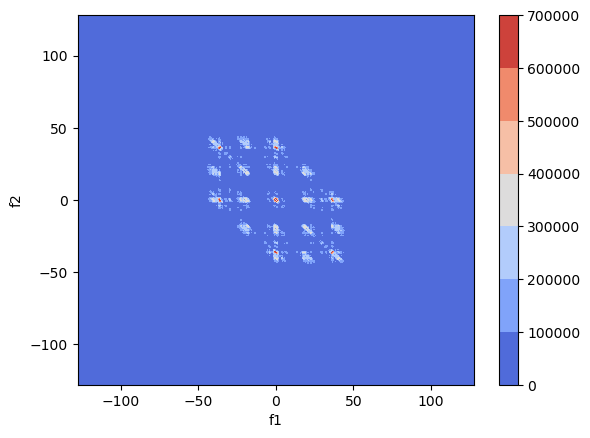

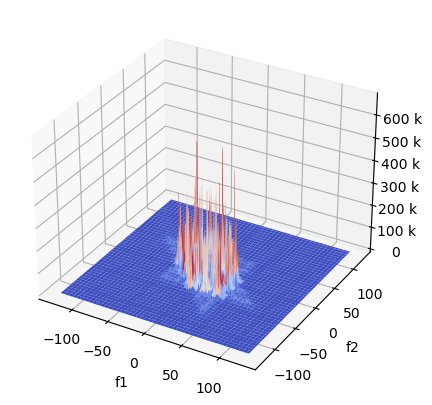

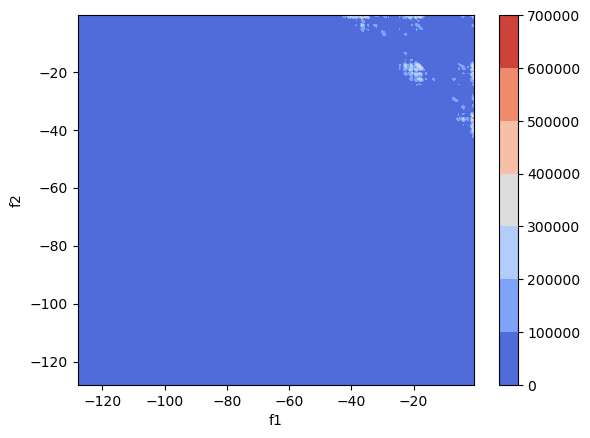

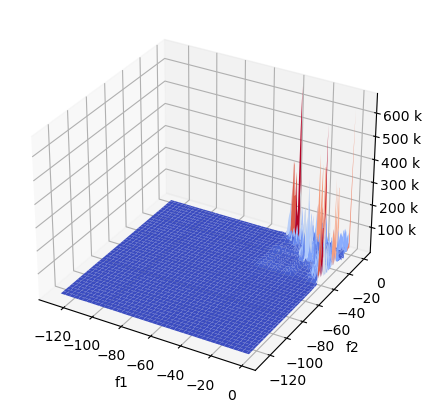

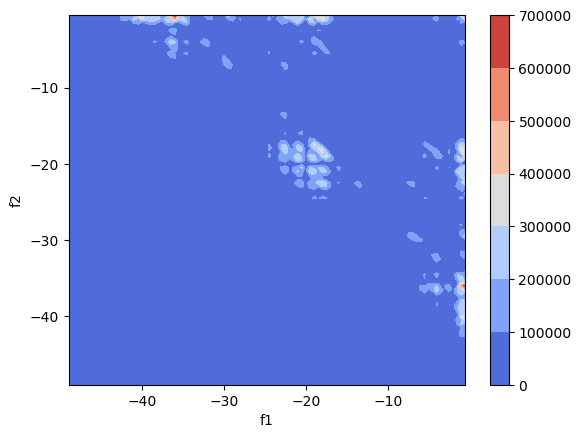

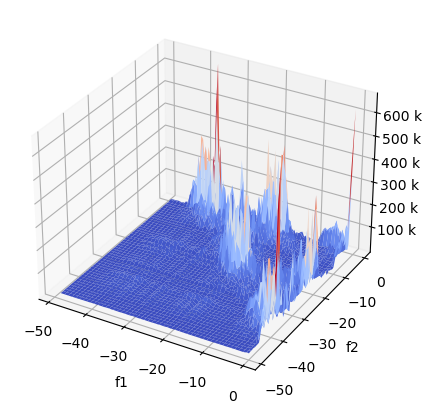

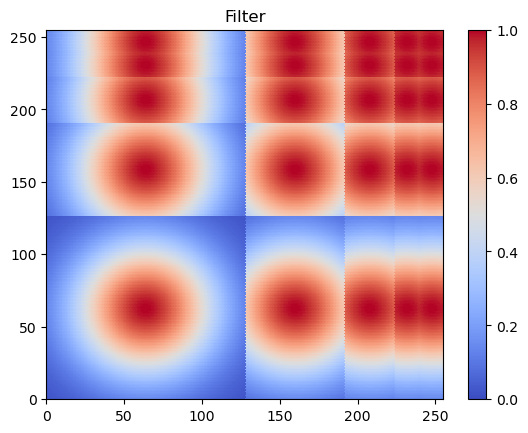

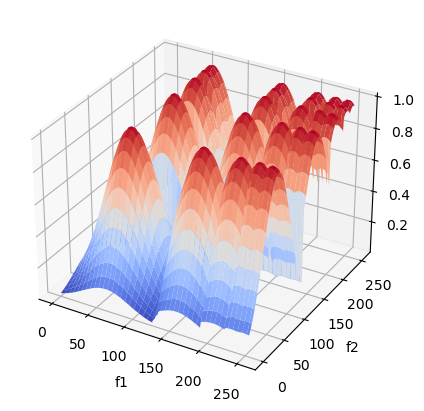

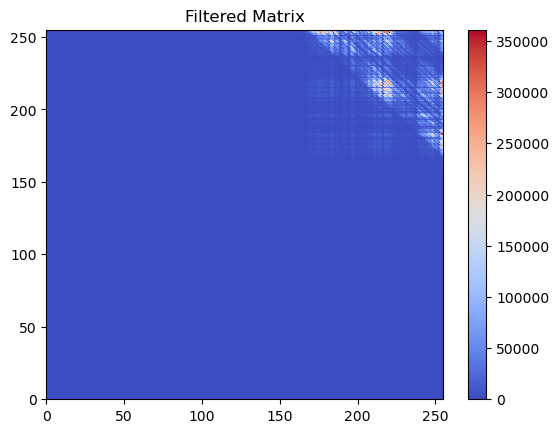

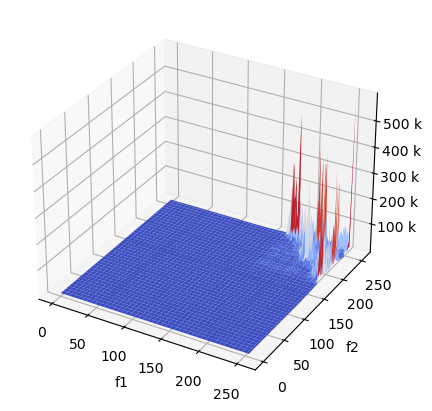

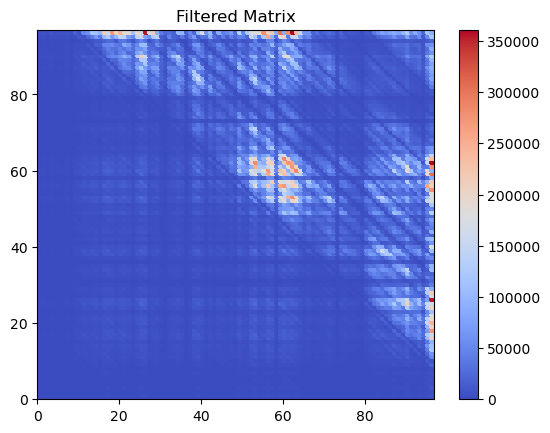

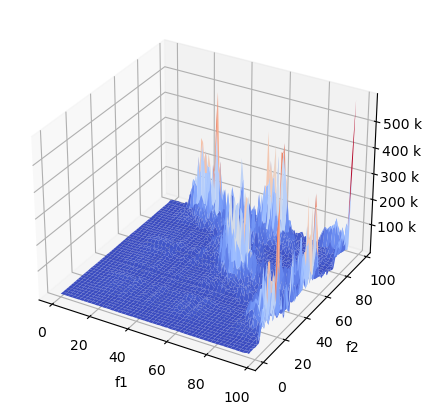

28942.515043899934


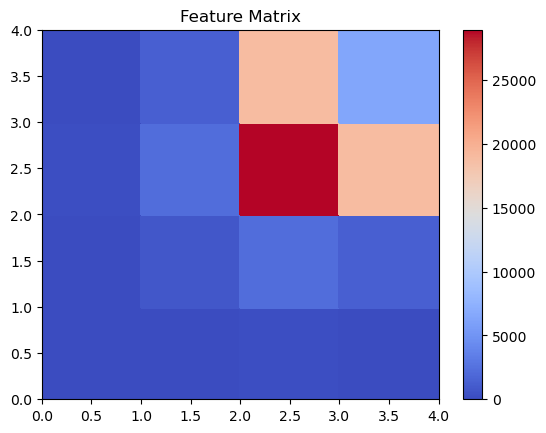

[[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]] [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


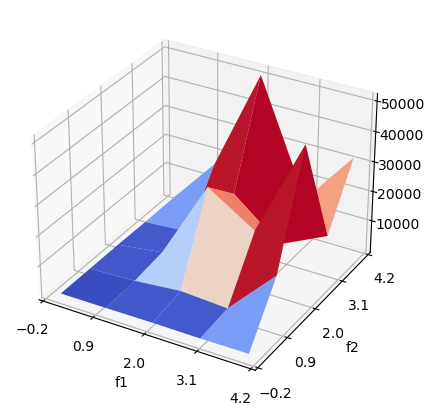

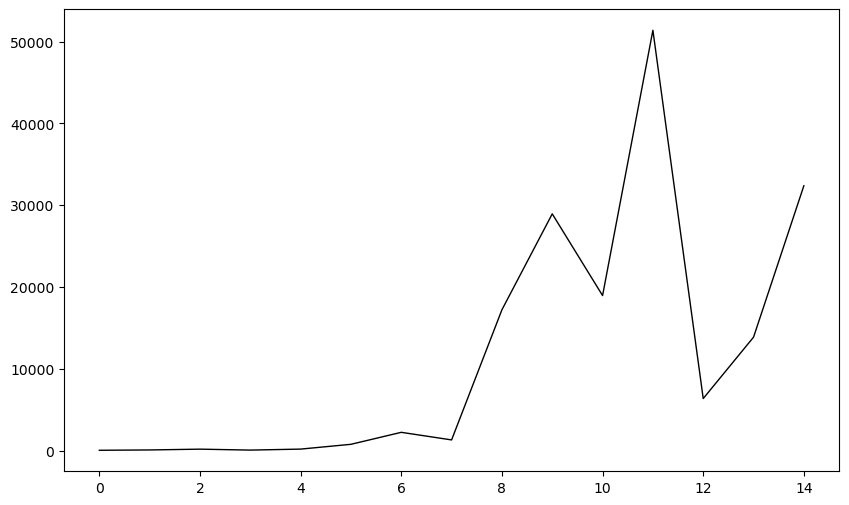

In [16]:
lag = 256
bis_dim = lag
big_fil_size = bis_dim //2
sigma = bis_dim//8
if sigma == 0:
    sigma = 1
fil_size = [big_fil_size // (2 ** i) for i in range(5)]

if sum(fil_size) != bis_dim:
        fil_size = [value for value in fil_size if value != 0]
        if len(fil_size) == 1:
            fil_size.append(fil_size[0])

fil_size[-1] = fil_size[-2] 
pyramid = np.zeros([bis_dim,bis_dim])
xtrack, ytrack = 0,0
for xdim in range(len(fil_size)):
    for ydim in range(len(fil_size)):
        x,y = fil_size[xdim], fil_size[ydim]
        pyramid[xtrack:xtrack+x, ytrack:ytrack+y] = gkernel(x, y, sigma)
        ytrack = ytrack+y
    ytrack = 0
    xtrack = xtrack+x
magnitude = calcBispec(get_dummy('../SMNI_CMI_TRAIN_CSV', lag), t, lag)
magnitude = magnitude[:256, :256]
feature = create_feature(magnitude,pyramid,fil_size, lag)

## Feature Visualization

In [19]:
# Load the CSV file into a DataFrame
bis_2 = np.load('./Test Bispec/2.npy')
bis_4 = np.load('./Test Bispec/4.npy')
bis_8 = np.load('./Test Bispec/8.npy')
bis_16 = np.load('./Test Bispec/16.npy')
bis_32 = np.load('./Test Bispec/32.npy')
bis_64 = np.load('./Test Bispec/64.npy')
bis_128 = np.load('./Test Bispec/128.npy')
bis_256 = np.load('./Test Bispec/256.npy')

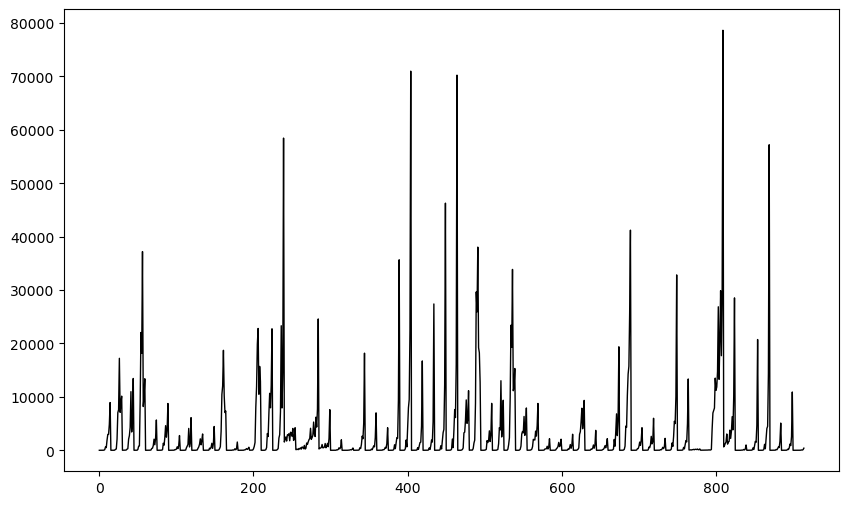

In [20]:

signal = bis_256
# Extract the signal values from the DataFrame

# Create a time axis for the signal
t = range(len(signal))

plt.figure(figsize=(10,6))
plt.plot(t, signal, color = 'k', linewidth=1)
plt.show()